# Latent Dirichlet Allocation

In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns 
sns.set_style("ticks")

In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

## Dirichlet distribution

### Gamma function
Given the $\Gamma$ function, with $z \in \mathbb{R}^+$:

$$
\Gamma(z) = \frac{e^{\gamma z}}{z} \prod\limits_{n=1}^{\infty} \left( 1 + \frac{z}{n} \right)^{-1} e^{\frac{z}{n}}
$$

with $\gamma = \lim\limits_{n \rightarrow \infty} \left( \sum\limits_{k=1}^{n} \frac{1}{k} - \ln n\right)$

In [3]:
from scipy.special import gamma

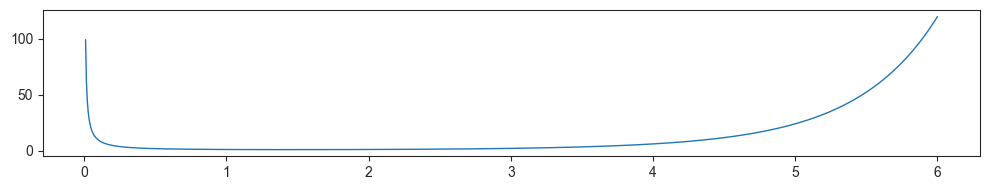

In [4]:
x = np.linspace(0.01, 6, 1000)
y = gamma(x)
fig, ax = plt.subplots(figsize=(10, 2))
sns.lineplot(x=x, y=y, ax=ax, linewidth=1)
plt.tight_layout()
plt.show()

### Beta function

Let's introduce the $\Beta$ function for $\vec{\alpha} = (\alpha_1, \dots, \alpha_k) > 0$

$$
\Beta(\vec{\alpha}) = \frac{\prod\limits_{i=1}^{k} \Gamma(\alpha_i)}{\Gamma\left(\sum\limits_{i=1}^{k} \alpha_i\right)}
$$

In [5]:
beta = lambda x: np.array([gamma(i) for i in x]).prod() / gamma(x.sum())
print(beta(np.array([0.1, 0.1, 0.1])))
print(beta(np.array([0.1, 0.2, 0.3])))

287.8213457465748
87.73672869050698


### Dirichlet density function

$$
f(\mathbf{x}; \vec{\alpha}) = \frac{1}{\Beta(\vec{\alpha})} \prod\limits_{i=1}^{k} x_{1}^{\alpha_i - 1}
$$

**2d example**

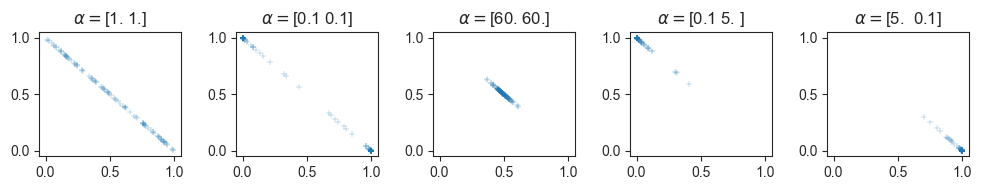

In [6]:
A = np.array([
    [1, 1],
    [.1, .1],
    [60, 60],
    [.1, 5],
    [5, .1],
])

fig, ax = plt.subplots(ncols=A.shape[0], figsize=(10, 2))
for i, alpha in enumerate(A):
    dist = np.random.dirichlet(alpha=alpha, size=100)
    sns.scatterplot(x=dist[:,0], y=dist[:, 1], ax=ax[i], alpha=.5, marker='+', size=.8, legend=False)
    ax[i].set_xlim((-0.05, 1.05))
    ax[i].set_ylim((-0.05, 1.05))
    ax[i].set_title(r"$\alpha = ${}".format(alpha))
plt.tight_layout()
plt.show()

**3d example**

In [7]:
dir_f = np.random.dirichlet

A = np.array([
    [1, 1, 1],
    [.1, .1, .1],
    [60, 60, 60],
    [.2, 1, 15],
    [15, 1, .2],
])

distributions = [dir_f(alpha=x, size=1000) for x in A]

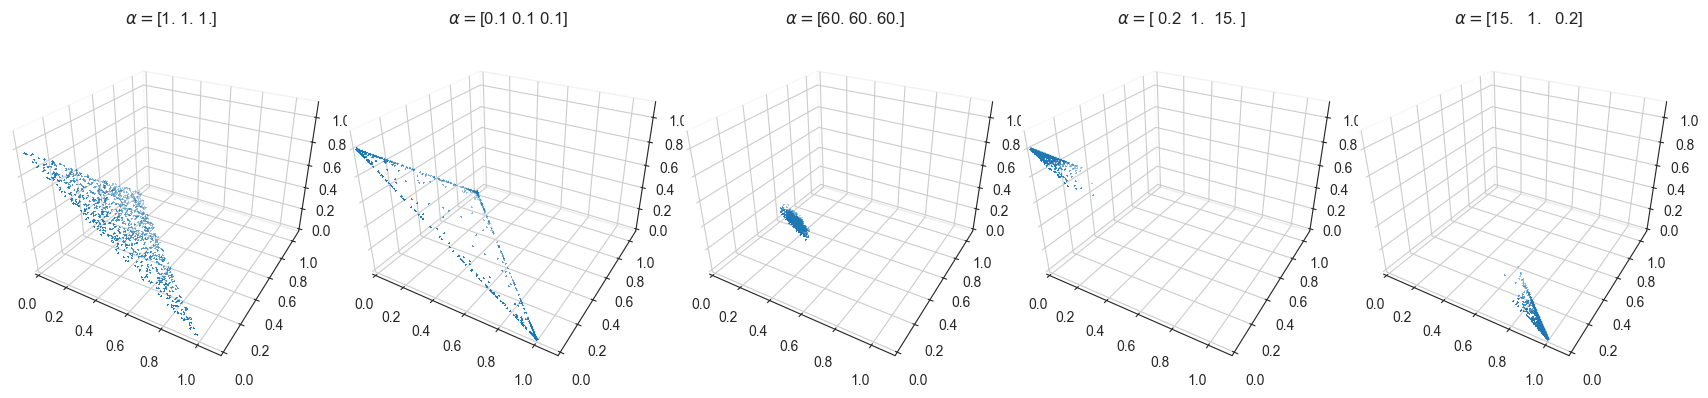

In [8]:
fig, ax = plt.subplots(ncols=A.shape[0], subplot_kw={'projection': '3d'}, figsize=(17, 4))
for i, d in enumerate(distributions):
    ax[i].xaxis.pane.fill = False
    ax[i].yaxis.pane.fill = False
    ax[i].zaxis.pane.fill = False
    ax[i].set_proj_type('persp', focal_length=0.28)
    ax[i].scatter(d[:,0], d[:,1], d[:,2], marker='+', s=.5)
    ax[i].set_title(r"$\alpha = ${}".format(str(A[i])))
    ax[i].set_xlim3d(left=0, right=1.1)
    ax[i].set_ylim3d(bottom=0, top=1.1)
    ax[i].set_zlim3d(bottom=0, top=1.1)
plt.tight_layout()
plt.show()

## Generative process
In order to generate texts using LDA, we need to fix the number $k$ of topics and:

- $\phi^{(k)} \sim Dir(\beta)$
- $N = Poisson(\zeta)$
- $\theta_d \sim Dir(\alpha)$

In this example, we derive $\phi$ for a bunch of documents.

In [10]:
from collections import defaultdict

In [11]:
documents = [
    ['napoleon', 'bonaparte', 'leader', 'battle'],
    ['napoleon', 'leader', 'battle', 'napoleon', 'waterloo'],
    ['leader', 'battle', 'bonaparte', 'waterloo'],
    ['city', 'united states', 'county'],
    ['napoleon', 'county'],
    ['missouri', 'kansas', 'city'],
    ['missouri', 'united states', 'city'],
    ['county', 'napoleon', 'leader', 'bonaparte', 'waterloo']
]
topics_annotations = [['history'], ['history'], ['history'], ['geography'], ['history', 'geography'],
                    ['geography'], ['geography'], ['history', 'geography']]

In [12]:
word_counts = defaultdict(lambda: defaultdict(lambda: 0))
for i, doc in enumerate(documents):
    for annotation in topics_annotations[i]:
        for word in doc:
            word_counts[word][annotation] += 1
wcount = pd.DataFrame(word_counts, dtype=float).fillna(0.001)
vocabulary = wcount.columns

In [13]:
wcount

,napoleon,bonaparte,leader,battle,waterloo,city,united states,county,missouri,kansas
history,5.0,3.0,4.0,3.000,3.0,0.001,0.001,2.0,0.001,0.001
geography,2.0,1.0,1.0,0.001,1.0,3.000,2.000,3.0,2.000,1.000


In [17]:
phi = pd.DataFrame(
    np.array([np.random.dirichlet(wcount.loc['history']), 
            np.random.dirichlet(wcount.loc['geography'])]), index=['history', 'geography'], columns=vocabulary)

In [18]:
phi

,napoleon,bonaparte,leader,battle,waterloo,city,united states,county,missouri,kansas
history,0.125408,0.230274,0.195209,1.423089e-01,0.201005,0.000000,0.000000,0.105795,0.000000,7.064632e-250
geography,0.261102,0.035262,0.062517,2.808587e-11,0.049011,0.165545,0.031213,0.256381,0.091325,4.764288e-02


In [19]:
h = pd.DataFrame(phi.loc['history']).reset_index()
g = pd.DataFrame(phi.loc['geography']).reset_index()

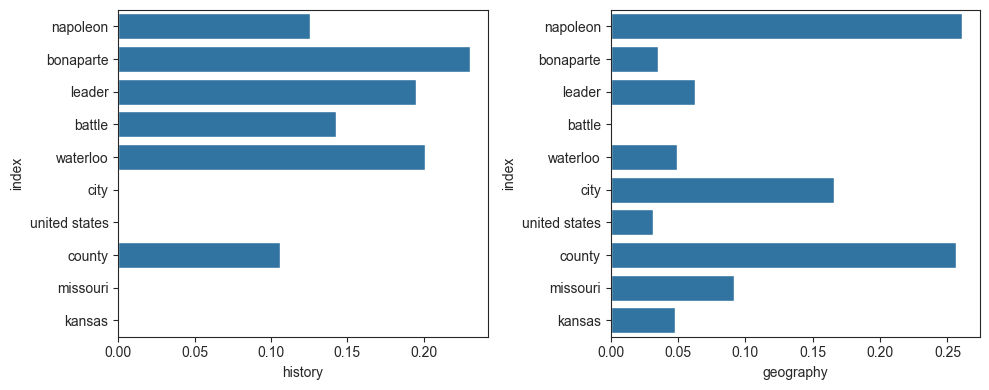

In [21]:
fig, ax = plt.subplots(ncols=phi.shape[0], figsize=(10, 4))
sns.barplot(data=h, y='index', x='history', ax=ax[0])
sns.barplot(data=g, y='index', x='geography', ax=ax[1])
plt.tight_layout()
plt.show()

### Documents generation

In [30]:
M = 20 # number of documents in the generated corpus
alpha = [.2, .2] # priors for the expected proportion of docs per topics
zeta = 8 # seed for the lenght of docs
topics = ['history', 'geography']

new_documents = []
for i in range(M):
    theta_d = np.random.dirichlet(alpha)
    N = np.random.poisson(zeta)
    new_document = []
    for w in range(N):
        selected_topic = np.random.choice(topics, p=theta_d)
        phi_z = phi.loc[selected_topic]
        word = np.random.choice(vocabulary, p=phi_z)
        new_document.append(word)
    new_documents.append(new_document)

In [31]:
for i, doc in enumerate(new_documents):
    print('DOC {}\t'.format(i+1), ", ".join(doc))

DOC 1	 county, missouri, napoleon, missouri, missouri, napoleon, napoleon
DOC 2	 county, napoleon, missouri, united states, county, napoleon, county
DOC 3	 city, county, missouri, leader, napoleon, city
DOC 4	 leader, county, waterloo, battle, leader, county, waterloo, waterloo, battle
DOC 5	 bonaparte, leader, leader, waterloo, bonaparte, leader, bonaparte, leader, battle, bonaparte, leader
DOC 6	 united states, napoleon, missouri, city, city, napoleon, napoleon, napoleon, napoleon, county
DOC 7	 county, bonaparte, waterloo, battle, bonaparte, county, county
DOC 8	 county, napoleon, leader, county
DOC 9	 leader, county, missouri, napoleon, city, county, county, missouri, napoleon, city, napoleon, county, kansas
DOC 10	 napoleon, bonaparte, county
DOC 11	 waterloo, napoleon, battle, leader, leader, leader
DOC 12	 battle, county
DOC 13	 napoleon, kansas, napoleon, bonaparte, napoleon, missouri, city, leader, county, county, missouri
DOC 14	 county, napoleon, leader, battle, napoleon, le

# Posterior inference with Gibbs sampling

## Init counters
We first set the number of topics $K$ and we randomly initialize some counters:

- $n_{d,k}$ number of words of the document $d$ assigned to $k$
- $n_{k,w}$ number of times (instances of) word $w$ is assigned to $k$
- $z$ array of assignments to topics for each of the words instances

In [32]:
from IPython.display import display

In [33]:
K = 2
N = sum(len(x) for x in documents)
alpha = np.array([.1]*K)
beta = np.array([.1]*len(vocabulary))

In [34]:
def init_gibbs():
    z = np.zeros(N)
    ndk = np.zeros((len(documents), K))
    nkw = np.zeros((K, len(vocabulary)))

    word_index = 0
    for i, doc in enumerate(documents):
        for word in doc:
            topic = np.random.choice(range(K))
            z[word_index] = topic
            ndk[i,topic] += 1
            nkw[topic, list(vocabulary).index(word)] += 1
            word_index += 1
    return z, ndk, nkw

def show(lda):
    z, ndk, nkw = lda
    Z = pd.DataFrame(z).T
    Z.columns = ["{}_{}".format(w, i) for i, w in enumerate([x for y in documents for x in y])]
    Ndk = pd.DataFrame(ndk)
    Nkw = pd.DataFrame(nkw, columns=vocabulary)
    display(Z)
    display(Ndk.T)
    display(Nkw)

In [53]:
lda_0 = init_gibbs()
show(lda_0)

,napoleon_0,bonaparte_1,leader_2,battle_3,napoleon_4,leader_5,battle_6,napoleon_7,waterloo_8,leader_9,...,kansas_19,city_20,missouri_21,united states_22,city_23,county_24,napoleon_25,leader_26,bonaparte_27,waterloo_28
0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


,0,1,2,3,4,5,6,7
0,0.0,2.0,1.0,2.0,1.0,3.0,1.0,2.0
1,4.0,3.0,3.0,1.0,1.0,0.0,2.0,3.0


,napoleon,bonaparte,leader,battle,waterloo,city,united states,county,missouri,kansas
0,2.0,2.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0
1,3.0,1.0,3.0,3.0,2.0,1.0,1.0,2.0,1.0,0.0


## Inference

- for iteration in iterations:
  - for document in documents:
    - for word in document:
      - topic = Z[word]
      - reduce counters for word and corresponding document
      - for topic in topics:
        - get P(topic) by the counters
        - new_topic = sample from P(topic)
        - Z[word] = new_topic
        - update counters

In [54]:
import copy

In [55]:
def theta(ndk, alpha, d_i, k_i):
    return (ndk[d_i, k_i] + alpha[k_i]) / (np.sum(ndk[d_i,:]) + sum(alpha))

def phi(nkw, beta, w_i, k_i):
    return (nkw[k_i, w_i] + beta[w_i]) / (np.sum(nkw[k_i,:] + sum(beta)))

def topic_distribution(doc_i, word_i, lda):
    z, ndk, nkw = lda
    p_z = np.zeros(K)
    for k_i in range(K):
        p_z[k_i] = theta(ndk, alpha, doc_i, k_i) * phi(nkw, beta, word_i, k_i)
    p_z = p_z / np.sum(p_z)

def gibbs(documents, vocabulary, lda, alpha, beta, iterations=10):
    voc = list(vocabulary)
    run = list(range(iterations))
    z, ndk, nkw = lda
    history = [(copy.deepcopy(z), copy.deepcopy(ndk), copy.deepcopy(nkw))]
    for it in tqdm(run):
        w_i = 0
        for doc_i, doc in enumerate(documents):
            for word in doc:
                current_topic = int(z[w_i])
                # Sample from p_z
                p_z = topic_distribution(doc_i, voc.index(word), (z, ndk, nkw))
                new_topic = np.random.choice(range(K), p=p_z)
                # Remove current assignment
                ndk[doc_i, current_topic] -= 1
                nkw[current_topic, voc.index(word)] -= 1
                # Update counters
                z[w_i] = new_topic
                ndk[doc_i, new_topic] += 1
                nkw[new_topic, voc.index(word)] += 1
                w_i += 1
        history.append((copy.deepcopy(z), copy.deepcopy(ndk), copy.deepcopy(nkw)))
    return history

In [56]:
lda_h = gibbs(documents, vocabulary, lda_0, alpha, beta, iterations=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [57]:
show(lda_h[-1])

,napoleon_0,bonaparte_1,leader_2,battle_3,napoleon_4,leader_5,battle_6,napoleon_7,waterloo_8,leader_9,...,kansas_19,city_20,missouri_21,united states_22,city_23,county_24,napoleon_25,leader_26,bonaparte_27,waterloo_28
0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


,0,1,2,3,4,5,6,7
0,2.0,3.0,0.0,2.0,1.0,2.0,2.0,2.0
1,2.0,2.0,4.0,1.0,1.0,1.0,1.0,3.0


,napoleon,bonaparte,leader,battle,waterloo,city,united states,county,missouri,kansas
0,1.0,0.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,0.0
1,4.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0


## System dinamics

In [58]:
from IPython.display import clear_output
import time

In [59]:
for lda_i in lda_h:
    cmd = input()
    if cmd == 'quit':
        break
    show(lda_i)
    clear_output(wait=True)

,napoleon_0,bonaparte_1,leader_2,battle_3,napoleon_4,leader_5,battle_6,napoleon_7,waterloo_8,leader_9,...,kansas_19,city_20,missouri_21,united states_22,city_23,county_24,napoleon_25,leader_26,bonaparte_27,waterloo_28
0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,0,1,2,3,4,5,6,7
0,2.0,2.0,3.0,1.0,1.0,2.0,1.0,0.0
1,2.0,3.0,1.0,2.0,1.0,1.0,2.0,5.0


,napoleon,bonaparte,leader,battle,waterloo,city,united states,county,missouri,kansas
0,3.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0
1,2.0,2.0,3.0,2.0,1.0,1.0,2.0,3.0,1.0,0.0


In [62]:
hist_terms = ['napoleon', 'bonaparte', 'leader']
geo_terms = ['city', 'county', 'united states']
h_indexes = [list(vocabulary).index(x) for x in hist_terms]
g_indexes = [list(vocabulary).index(x) for x in geo_terms]

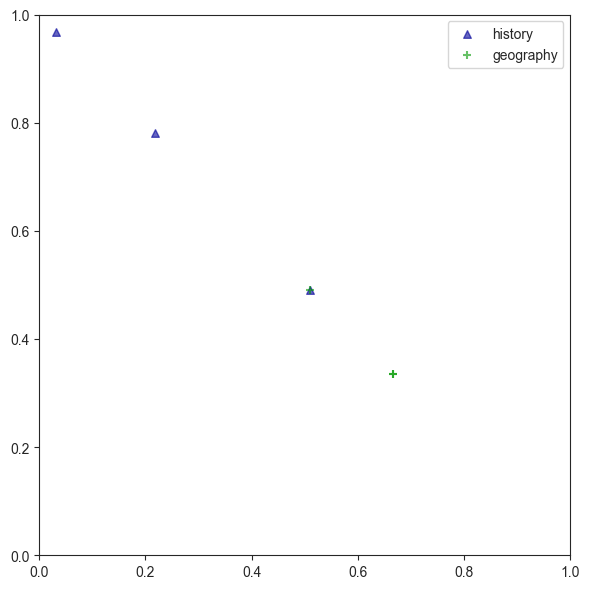

In [63]:
every = range(0, len(lda_h), 100)

for experiment in every:
    z, ndk, nkw = lda_h[experiment]
    H = []
    for h in h_indexes:
        p = np.array([phi(nkw, beta, h, t) for t in range(K)])
        p = p / p.sum()
        H.append(p)
    H = np.array(H)
    G = []
    for g in g_indexes:
        p = np.array([phi(nkw, beta, g, t) for t in range(K)])
        p = p / p.sum()
        G.append(p)
    G = np.array(G)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(H[:,0], H[:,1], label='history', c='#000099', alpha=.6, marker='^', s=30)
    ax.scatter(G[:,0], G[:,1], label='geography', c='#009900', alpha=.6, marker='+', s=30)
    ax.set_xlim((0,1))
    ax.set_ylim((0,1))
    ax.legend()
    plt.tight_layout()
    plt.show()
    clear_output(wait=True)

## Gensim implementation

In [90]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

In [92]:
documents = [
    ['napoleon', 'bonaparte', 'leader', 'battle'],
    ['napoleon', 'leader', 'battle', 'napoleon', 'waterloo'],
    ['leader', 'battle', 'bonaparte', 'waterloo'],
    ['city', 'united states', 'county'],
    ['napoleon', 'county'],
    ['missouri', 'kansas', 'city'],
    ['missouri', 'united states', 'city'],
    ['county', 'napoleon', 'leader', 'bonaparte', 'waterloo']
]

In [93]:
dictionary = Dictionary(documents)
corpus = [dictionary.doc2bow(text) for text in documents]

In [95]:
dictionary.doc2bow(['napoleon', 'napoleon', 'battle'])

[(0, 1), (3, 2)]

In [99]:
lda = LdaModel(corpus=corpus, num_topics=3)

**Term-topic matrix**

In [1]:
m = lda.get_topics()
T = pd.DataFrame(m, columns=[dictionary[x] for x in range(m.shape[1])])
T 

NameError: name 'lda' is not defined

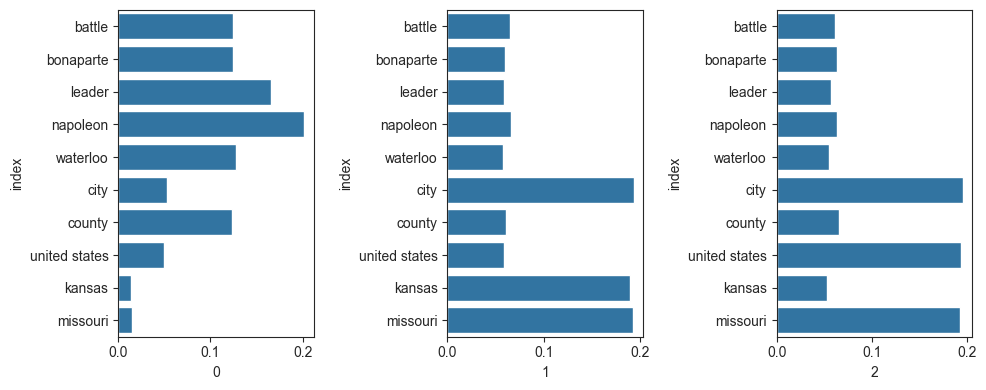

In [102]:
t_0 = pd.DataFrame(T.loc[0]).reset_index()
t_1 = pd.DataFrame(T.loc[1]).reset_index()
t_2 = pd.DataFrame(T.loc[2]).reset_index()

fig, ax = plt.subplots(ncols=T.shape[0], figsize=(10, 4))
sns.barplot(data=t_0, y='index', x=0, ax=ax[0])
sns.barplot(data=t_1, y='index', x=1, ax=ax[1])
sns.barplot(data=t_2, y='index', x=2, ax=ax[2])
plt.tight_layout()
plt.show()

### Example with generated text

In order to demonstrate lda, we work on some generated text using `BERT` as masking model.

In [103]:
from transformers import pipeline, set_seed

In [104]:
generator = pipeline('fill-mask', model='bert-base-uncased')
set_seed(42)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [105]:
generator("I am a professor and I like to [MASK] computer science")

[{'score': 0.4394477307796478,
  'token': 2817,
  'token_str': 'study',
  'sequence': 'i am a professor and i like to study computer science'},
 {'score': 0.29381823539733887,
  'token': 6570,
  'token_str': 'teach',
  'sequence': 'i am a professor and i like to teach computer science'},
 {'score': 0.06435706466436386,
  'token': 2377,
  'token_str': 'play',
  'sequence': 'i am a professor and i like to play computer science'},
 {'score': 0.04277674853801727,
  'token': 3191,
  'token_str': 'read',
  'sequence': 'i am a professor and i like to read computer science'},
 {'score': 0.032740384340286255,
  'token': 3218,
  'token_str': 'practice',
  'sequence': 'i am a professor and i like to practice computer science'}]

In [71]:
def fill_mask(intervention, generator):
    tokens, sequences = [], []
    prompt = f"I am a {intervention} and I work in the [MASK] field."
    words = generator(prompt)
    for word in words:
        tokens.append(word['token_str'])
        sequences.append(word['sequence'])
    return tokens, sequences        

In [107]:
topics = ['scientist', 'athlete']
docs_per_topic = 200
documents = []
words = []
for topic in topics:
    for i in range(docs_per_topic):
        w, s = fill_mask(topic, generator=generator)
        words.extend(w)
        documents.extend(s)
np.random.shuffle(documents)
    

In [108]:
print(len(documents))
documents[:6]

2000


['i am a athlete and i work in the sports field.',
 'i am a scientist and i work in the research field.',
 'i am a athlete and i work in the athletic field.',
 'i am a scientist and i work in the same field.',
 'i am a athlete and i work in the same field.',
 'i am a athlete and i work in the athletic field.']

In [109]:
observed = list(set(words)) + topics
print(observed)  

['football', 'athletic', 'medical', 'scientific', 'athletics', 'sports', 'physics', 'research', 'same', 'scientist', 'athlete']


### LDA

In [110]:
docs = [d.lower().split() for d in documents]
dictionary = Dictionary(docs)
corpus = [dictionary.doc2bow(text) for text in docs]

In [124]:
lda = LdaModel(corpus=corpus, num_topics=2)

In [125]:
m = lda.get_topics()
T = pd.DataFrame(m, columns=[dictionary[x] for x in range(m.shape[1])])[observed]
T

,football,athletic,medical,scientific,athletics,sports,physics,research,same,scientist,athlete
0,0.007813,0.007734,0.008754,0.010826,0.009625,0.009594,0.010019,0.006662,0.018276,0.052135,0.042402
1,0.012603,0.012810,0.010117,0.004645,0.007818,0.007899,0.006778,0.015642,0.018041,0.027838,0.053537


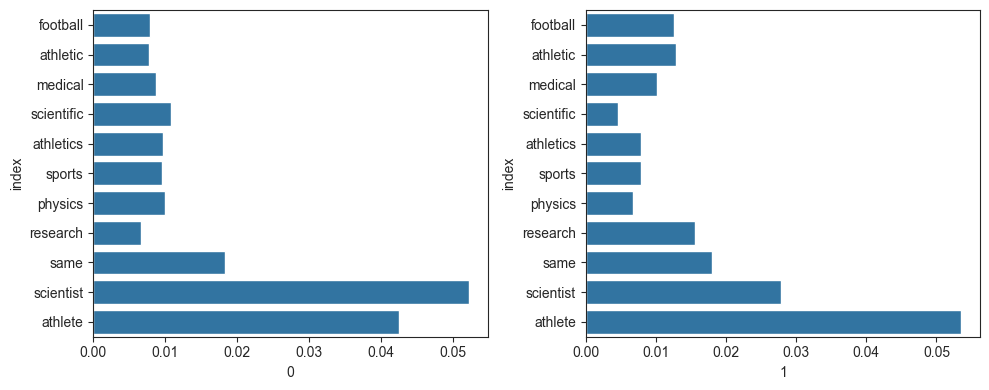

In [126]:
t_0 = pd.DataFrame(T.loc[0]).reset_index()
t_1 = pd.DataFrame(T.loc[1]).reset_index()

fig, ax = plt.subplots(ncols=T.shape[0], figsize=(10, 4))
sns.barplot(data=t_0, y='index', x=0, ax=ax[0])
sns.barplot(data=t_1, y='index', x=1, ax=ax[1])
plt.tight_layout()
plt.show()

#### Document-topic

In [127]:
d1, d2 = 100, 1515
print(documents[d1])
print(documents[d2])

i am a scientist and i work in the scientific field.
i am a athlete and i work in the athletic field.


In [128]:
print(lda.get_document_topics(corpus[d1]))
print(lda.get_document_topics(corpus[d2]))

[(0, 0.9065965), (1, 0.093403526)]
[(0, 0.18751815), (1, 0.8124818)]


### Topic-terms

In [129]:
for word, p in lda.get_topic_terms(0, topn=200):
    if dictionary[word] in observed:
        print(f"{dictionary[word]:10} {p}")

scientist  0.05213477090001106
athlete    0.0424019917845726
same       0.01827595941722393
scientific 0.010826430283486843
physics    0.010018832981586456
athletics  0.00962479505687952
sports     0.009594161063432693
medical    0.008754194714128971
football   0.007812673225998878
athletic   0.007734258193522692
research   0.006661708001047373


In [130]:
for word, p in lda.get_topic_terms(1, topn=200):
    if dictionary[word] in observed:
        print(f"{dictionary[word]:10} {p}")

athlete    0.05353745073080063
scientist  0.02783817984163761
same       0.01804143562912941
research   0.01564190350472927
athletic   0.012809916399419308
football   0.012602878734469414
medical    0.01011673267930746
sports     0.007898859679698944
athletics  0.007817949168384075
physics    0.006777531933039427
scientific 0.004645087290555239


## Use topics as vector dimensions

In [131]:
topics = ['scientist', 'athlete']
M = np.zeros((len(documents), len(topics)))
truth = []
for d, doc in enumerate(documents):
    words = doc.split()
    topic = words[3]
    truth.append(topics.index(topic))
    assignment = dict(lda.get_document_topics(corpus[d]))
    M[d,0] = assignment[0]
    M[d,1] = assignment[1]
    

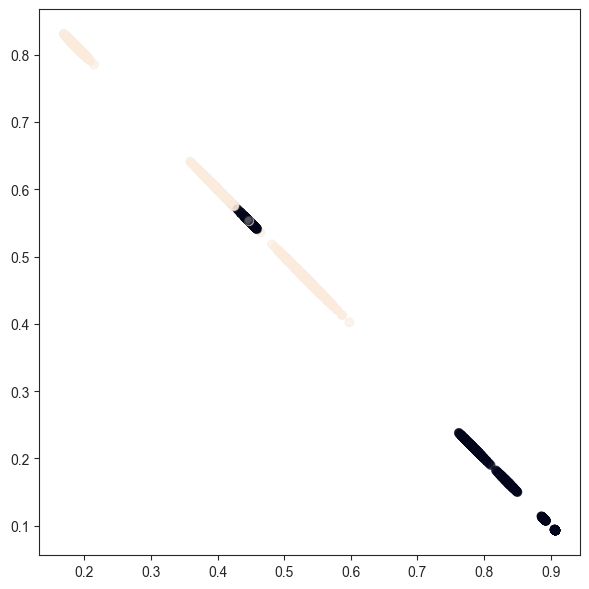

In [132]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(M[:,0], M[:,1], alpha=0.6, c=truth)
plt.tight_layout()
plt.show()